# GNN on Simple Traffic Graph

This is all well and good for Graph Neural Networks but what if you need a time-series example for the GNN?

Suppose you have 10 nodes in your graph and 100 time steps. We need to setup the gnn such that it is able to predict correctly

torch==1.9.0
torch_geometric==1.7.2
networkx==2.6.2
matplotlib==3.4.3
numpy==1.21.2
pandas==1.3.3
pyyaml==5.4.1

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Simulate traffic data: 10 nodes (e.g., sensors) with 100 time steps
num_nodes = 10
num_timesteps = 100

# Generate random time series data for each node
time_series_data = np.random.rand(num_timesteps, num_nodes)

# Create edge index for a simple graph (e.g., ring graph)
edge_index = torch.tensor([[i, (i + 1) % num_nodes] for i in range(num_nodes)] +
                          [[(i + 1) % num_nodes, i] for i in range(num_nodes)], dtype=torch.long).t().contiguous()

# Convert time series data to PyTorch tensor
x = torch.tensor(time_series_data, dtype=torch.float).t().contiguous().view(num_nodes, num_timesteps, 1)

# Create data object
data = Data(x=x, edge_index=edge_index)


Create a temporal GNN class

In [2]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, num_nodes, num_timesteps, input_dim, hidden_dim, output_dim):
        super(TemporalGNN, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.lstm = torch.nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.gcn2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch_size, num_timesteps, input_dim = x.size()
        
        # Apply GCN to each time step
        x = x.view(batch_size * num_timesteps, input_dim)
        x = F.relu(self.gcn1(x, edge_index))
        x = x.view(batch_size, num_timesteps, -1)
        
        # Apply LSTM for temporal modeling
        x, _ = self.lstm(x)
        
        # Apply GCN to the output of LSTM
        x = x.contiguous().view(batch_size * num_timesteps, -1)
        x = self.gcn2(x, edge_index)
        x = x.view(batch_size, num_timesteps, -1)
        
        return x

In [3]:
# Initialize the model
num_nodes = 10
num_timesteps = 100
input_dim = 1
hidden_dim = 32
output_dim = 1
model = TemporalGNN(num_nodes, num_timesteps, input_dim, hidden_dim, output_dim)

# Simulate target data for training
y = torch.rand(num_nodes, num_timesteps, output_dim)
data.y = y

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Training loop
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 0.43213868141174316
Epoch 20, Loss: 0.08285564929246902
Epoch 40, Loss: 0.08133874833583832
Epoch 60, Loss: 0.08106055110692978
Epoch 80, Loss: 0.08088484406471252
Epoch 100, Loss: 0.08080519735813141
Epoch 120, Loss: 0.08076100051403046
Epoch 140, Loss: 0.08073367178440094
Epoch 160, Loss: 0.080714650452137
Epoch 180, Loss: 0.0806993767619133


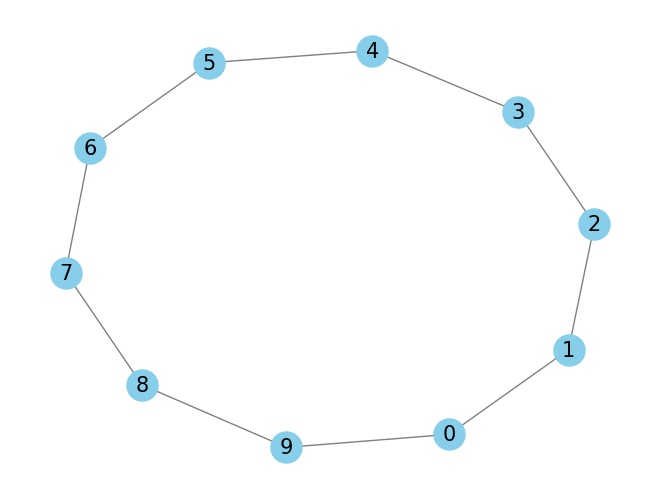

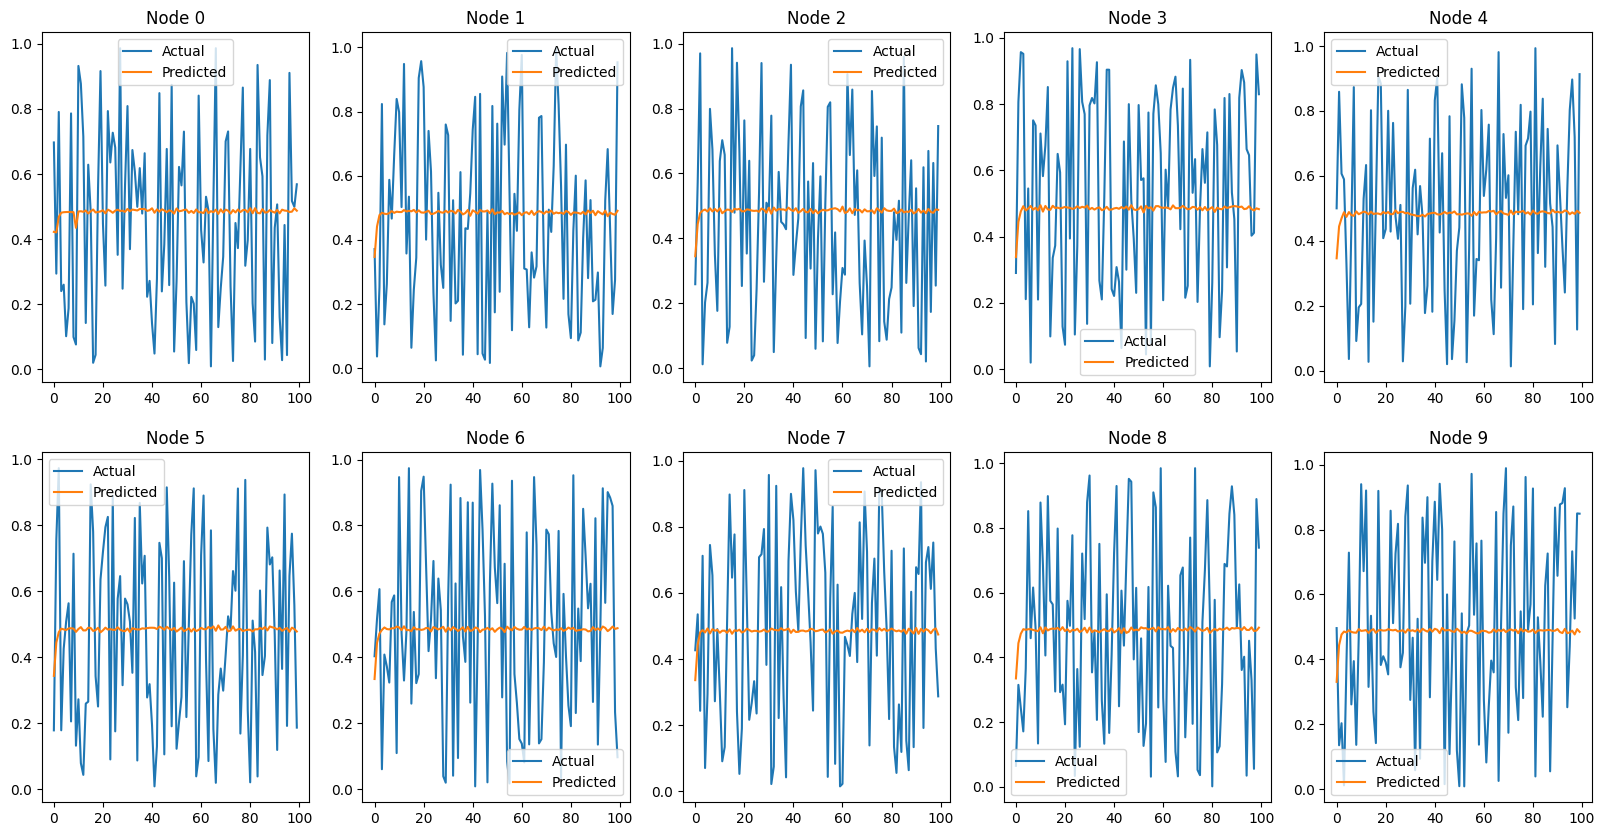

In [4]:
# Visualization of the graph
def plot_graph(edge_index, num_nodes):
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=15)
    plt.show()

plot_graph(edge_index, num_nodes)

# Get the final node embeddings
model.eval()
with torch.no_grad():
    out = model(data)

# Plot the actual and predicted time series for each node
plt.figure(figsize=(20, 10))
for i in range(num_nodes):
    plt.subplot(2, 5, i + 1)
    plt.plot(data.y[i, :, 0].numpy(), label='Actual')
    plt.plot(out[i, :, 0].numpy(), label='Predicted')
    plt.title(f'Node {i}')
    plt.legend()
plt.show()


As you can see the performance looks very bad so we have Gen AI change up the model a bit
- Add in a sine wave to better show real world data (simulated data changed)
- Increased the LSTM layers and added in another GCN for better capacity
- Increased Training Epochs to 500
- Learning Rate reduced to 0.001 for better convergence

# Using GNN on simple Traffic data [UPDATED]

In [5]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Simulate more structured traffic data: 10 nodes (e.g., sensors) with 100 time steps
num_nodes = 10
num_timesteps = 100

# Generate time series data with a pattern
time_series_data = np.sin(np.linspace(0, 100, num_timesteps)).reshape(-1, 1) + np.random.randn(num_timesteps, num_nodes) * 0.1

# Create edge index for a simple graph (e.g., ring graph)
edge_index = torch.tensor([[i, (i + 1) % num_nodes] for i in range(num_nodes)] +
                          [[(i + 1) % num_nodes, i] for i in range(num_nodes)], dtype=torch.long).t().contiguous()

# Convert time series data to PyTorch tensor
x = torch.tensor(time_series_data, dtype=torch.float).t().contiguous().view(num_nodes, num_timesteps, 1)

# Create data object
data = Data(x=x, edge_index=edge_index)


In [6]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, num_nodes, num_timesteps, input_dim, hidden_dim, output_dim):
        super(TemporalGNN, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.lstm = torch.nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.gcn3 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch_size, num_timesteps, input_dim = x.size()
        
        # Apply GCN to each time step
        x = x.view(batch_size * num_timesteps, input_dim)
        x = F.relu(self.gcn1(x, edge_index))
        x = x.view(batch_size, num_timesteps, -1)
        
        # Apply LSTM for temporal modeling
        x, _ = self.lstm(x)
        
        # Apply GCN to the output of LSTM
        x = x.contiguous().view(batch_size * num_timesteps, -1)
        x = F.relu(self.gcn2(x, edge_index))
        x = self.gcn3(x, edge_index)
        x = x.view(batch_size, num_timesteps, -1)
        
        return x

Epoch 0, Loss: 0.5126954317092896
Epoch 50, Loss: 0.038109589368104935
Epoch 100, Loss: 0.017887089401483536
Epoch 150, Loss: 0.016566790640354156
Epoch 200, Loss: 0.015717623755335808
Epoch 250, Loss: 0.015071847476065159
Epoch 300, Loss: 0.014495563693344593
Epoch 350, Loss: 0.013997814618051052
Epoch 400, Loss: 0.013607501983642578
Epoch 450, Loss: 0.01327336486428976


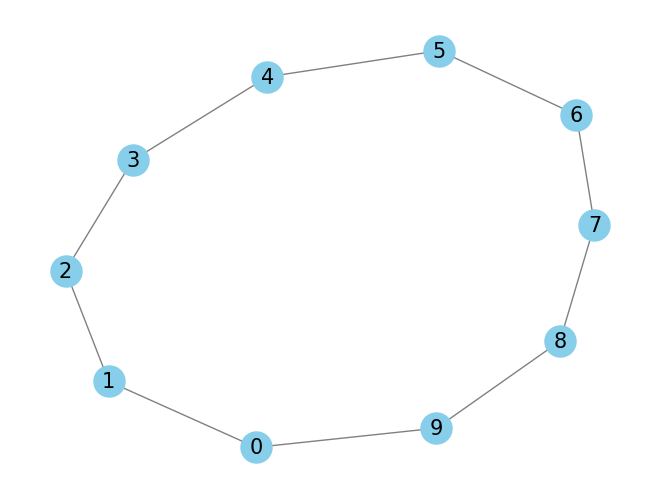

In [7]:
# Initialize the model
input_dim = 1
hidden_dim = 32
output_dim = 1
model = TemporalGNN(num_nodes, num_timesteps, input_dim, hidden_dim, output_dim)

# Simulate target data for training
y = torch.sin(torch.linspace(0, 100, num_timesteps)).reshape(-1, 1) + torch.randn(num_timesteps, num_nodes) * 0.1
y = y.t().contiguous().view(num_nodes, num_timesteps, 1)
data.y = y

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training loop
model.train()
for epoch in range(500):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Visualization of the graph
def plot_graph(edge_index, num_nodes):
    G = nx.Graph()
    G.add_edges_from(edge_index.t().tolist())
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=15)
    plt.show()

plot_graph(edge_index, num_nodes)

# Get the final node embeddings
model.eval()
with torch.no_grad():
    out = model(data)

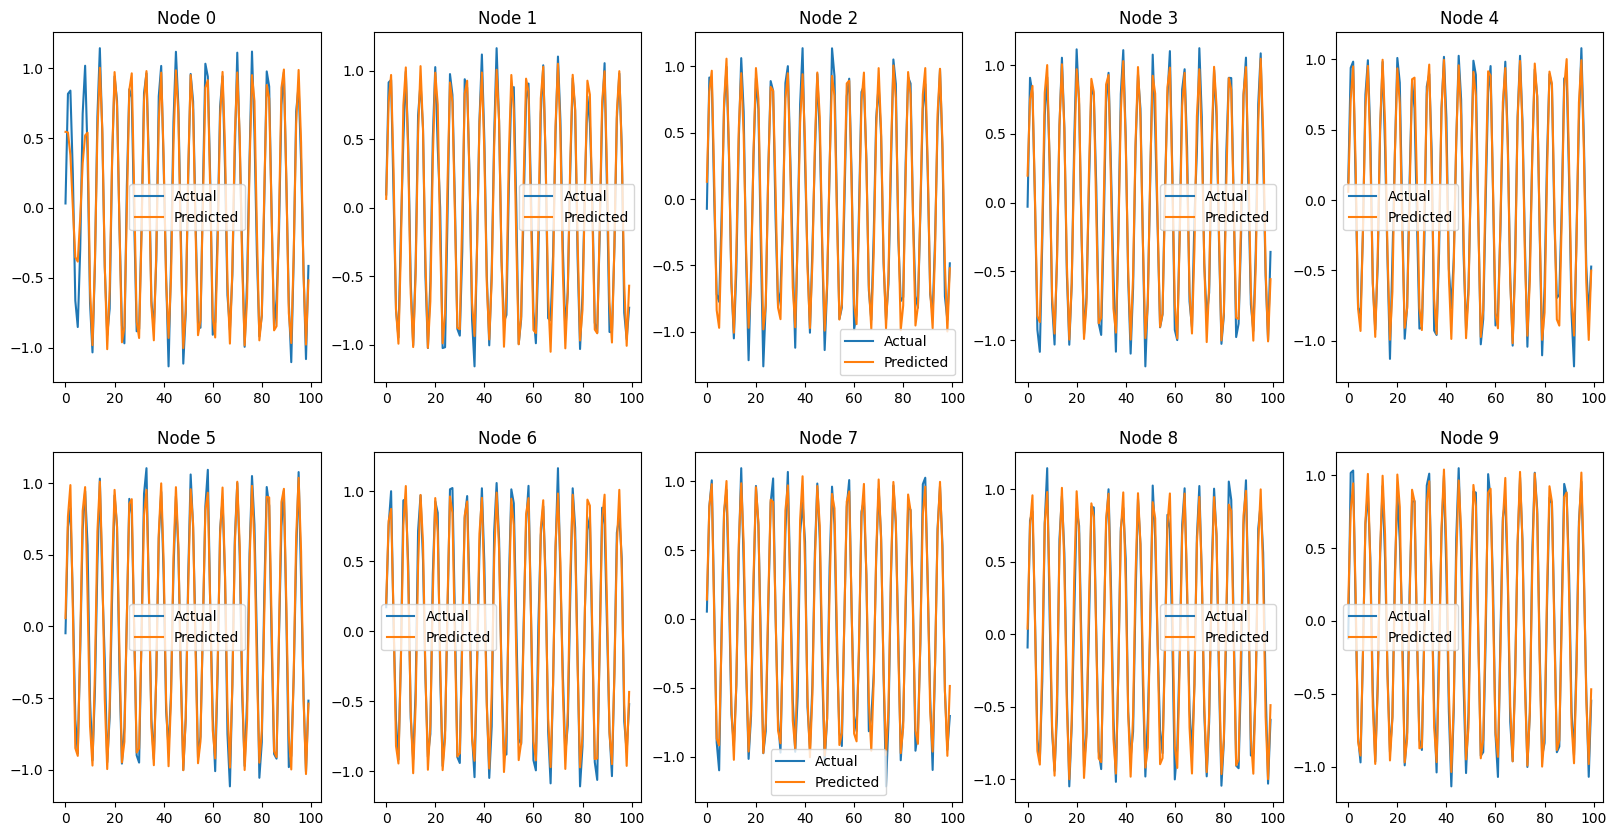

In [8]:
# Plot the actual and predicted time series for each node
plt.figure(figsize=(20, 10))
for i in range(num_nodes):
    plt.subplot(2, 5, i + 1)
    plt.plot(data.y[i, :, 0].numpy(), label='Actual')
    plt.plot(out[i, :, 0].numpy(), label='Predicted')
    plt.title(f'Node {i}')
    plt.legend()
plt.show()

This mimics better performance for the aforementioned reasons

# Using Gen AI on map data

torch
torch_geometric
networkx
matplotlib
numpy
pandas
pyyaml
osmnx
folium

In [9]:
import osmnx as ox
import networkx as nx
import numpy as np
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

# Get the road network of downtown Vancouver
place_name = "Downtown, Vancouver, British Columbia, Canada"
G = ox.graph_from_place(place_name, network_type='drive')

# Get the largest strongly connected component
largest_scc = max(nx.strongly_connected_components(G), key=len)
G = G.subgraph(largest_scc).copy()

# Check if the graph is already simplified
if "simplified" not in G.graph or not G.graph["simplified"]:
    # Simplify the graph
    G = ox.simplify_graph(G)


C:\Users\afraz.khan\Anaconda3\envs\mlenv2\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\afraz.khan\Anaconda3\envs\mlenv2\lib\site-packages\osmnx\convert.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https

In [10]:
# Get the number of nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Simulate traffic data: 100 time steps of traffic flow data for each edge
num_timesteps = 100
traffic_data = np.random.rand(num_edges, num_timesteps)

# Get edge index
edges = list(G.edges)
edge_index = np.array([[list(G.nodes).index(edge[0]), list(G.nodes).index(edge[1])] for edge in edges]).T


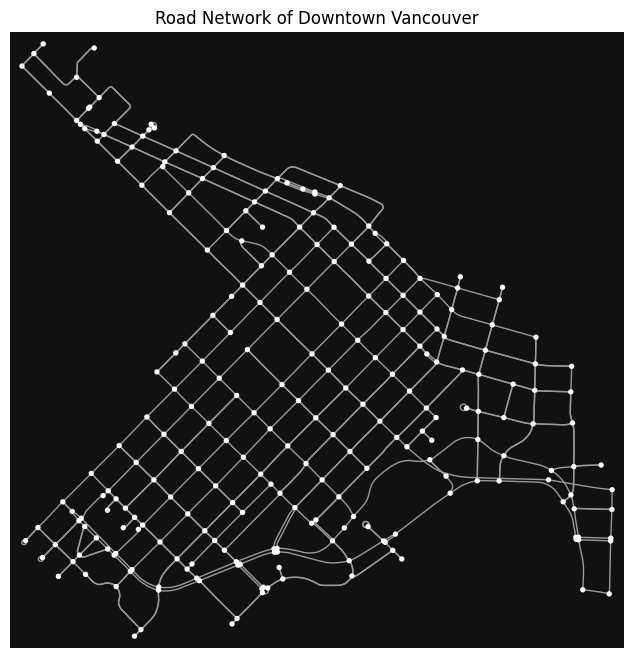

In [11]:
import matplotlib.pyplot as plt

# Plot the graph on Vancouver's map
fig, ax = ox.plot_graph(G, show=False, close=False)
plt.title("Road Network of Downtown Vancouver")
plt.show()


In [12]:
from ipyleaflet import Map, basemaps, basemap_to_tiles

# Create a map centered around downtown Vancouver
center = (49.2827, -123.1207)
zoom = 13
m = Map(center=center, zoom=zoom)

# Add a satellite basemap
satellite_layer = basemap_to_tiles(basemaps.Esri.WorldImagery)
m.add_layer(satellite_layer)

# Display the map
m


Map(center=[49.2827, -123.1207], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', '…

In [13]:
import torch
from torch_geometric.data import Data

# Convert traffic data to PyTorch tensor
x = torch.tensor(traffic_data, dtype=torch.float)

# Convert edge index to PyTorch tensor
edge_index = torch.tensor(edge_index, dtype=torch.long)

# Create data object
data = Data(x=x, edge_index=edge_index)


In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class TrafficGNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=16):
        super(TrafficGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize model, optimizer, and loss function
input_dim = num_timesteps
output_dim = num_timesteps
model = TrafficGNN(input_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Train the model
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.x)
    loss.backward()
    optimizer.step()
    return loss.item()

# Train for 200 epochs
for epoch in range(200):
    loss = train()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss:.4f}')


Epoch 10, Loss: 0.1210
Epoch 20, Loss: 0.0944
Epoch 30, Loss: 0.0900
Epoch 40, Loss: 0.0859
Epoch 50, Loss: 0.0840
Epoch 60, Loss: 0.0830
Epoch 70, Loss: 0.0824
Epoch 80, Loss: 0.0820
Epoch 90, Loss: 0.0817
Epoch 100, Loss: 0.0814
Epoch 110, Loss: 0.0813
Epoch 120, Loss: 0.0811
Epoch 130, Loss: 0.0810
Epoch 140, Loss: 0.0809
Epoch 150, Loss: 0.0808
Epoch 160, Loss: 0.0807
Epoch 170, Loss: 0.0806
Epoch 180, Loss: 0.0805
Epoch 190, Loss: 0.0805
Epoch 200, Loss: 0.0804


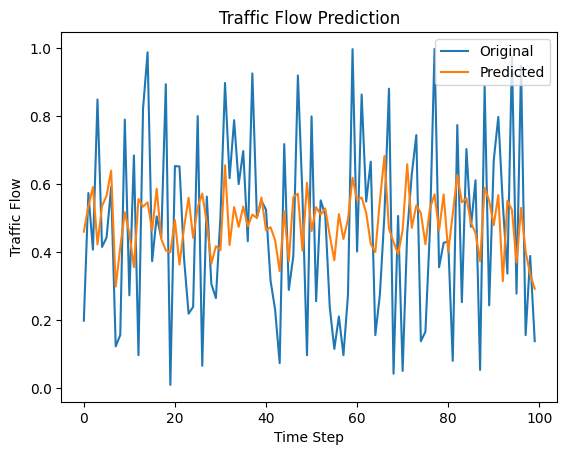

In [15]:
import matplotlib.pyplot as plt

# Plot the original and predicted traffic flow for a random edge
random_edge = np.random.choice(num_edges)
original_flow = data.x[random_edge].detach().numpy()
predicted_flow = model(data)[random_edge].detach().numpy()

plt.plot(original_flow, label='Original')
plt.plot(predicted_flow, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Traffic Flow')
plt.legend()
plt.title('Traffic Flow Prediction')
plt.show()

Why is the prediction so underwhelming:

1. **Increase Model Capacity**: Try increasing the hidden dimension size and/or the number of layers in your GNN to allow the model to capture more complex patterns in the data.

2. **Adjust Learning Rate**: Experiment with different learning rates to find the one that works best for your model. Sometimes a smaller learning rate can lead to better convergence.

3. **Use Different Activation Functions**: Instead of using ReLU activation, try other activation functions like Leaky ReLU, ELU, or GELU to see if they improve performance.

4. **Regularization**: Add L2 regularization to the weights of your model to prevent overfitting. You can do this by adding the weight_decay parameter to your optimizer.

5. **Gradient Clipping**: Implement gradient clipping to prevent exploding gradients, which can sometimes lead to poor performance.

6. **Feature Engineering**: Consider adding more features to your input data that could help improve the model's ability to predict traffic flow.

7. **Hyperparameter Tuning**: Experiment with different hyperparameters such as batch size, dropout rate, and number of epochs to find the best combination for your model.

8. **Data Preprocessing**: Ensure that your data is properly preprocessed and normalized before training the model. This can have a significant impact on performance.

9. **Model Evaluation**: Use appropriate evaluation metrics such as Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE) to evaluate the performance of your model and compare it with the actual traffic flow data.

10. **Advanced Techniques**: Consider using more advanced techniques such as graph attention networks (GATs) or graph convolutional LSTM networks (GC-LSTM) for better performance on spatial-temporal data like traffic flow.